In [1]:
from generate_samples import SyntheticDAG
from causal_peeler_e import *
# from causal_peeler import *
from causal_peeler_t import *
from ssm import *
import csv
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from torch.autograd.functional import jacobian
import pandas as pd
from tabulate import tabulate
import seaborn as sns
from random import random
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from gurobipy import GRB
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import t
from scipy.optimize import curve_fit
from statsmodels.tsa.holtwinters import ExponentialSmoothing

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/ryanwelch/opt/anaconda3/envs/causal2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def SER(true_matrices, estimated_matrices):
    total_true_norm = sum(np.linalg.norm(A, 'fro')**2 for A in true_matrices)
    total_error_norm = sum(np.linalg.norm(A - A_hat, 'fro')**2 for A, A_hat in zip(true_matrices, estimated_matrices))
    global_SER = total_true_norm / total_error_norm
    global_SER_dB = 10 * np.log10(global_SER)
    return global_SER, global_SER_dB

def perturb(true_matrices, desired_SER_dB):
    # Convert SER dB to linear scale
    desired_SER_linear = 10 ** (desired_SER_dB / 10)

    # Calculate total signal power
    total_true_norm = sum(np.linalg.norm(A, 'fro')**2 for A in true_matrices)

    # Calculate total noise power based on desired SER
    total_noise_power = total_true_norm / desired_SER_linear

    # Number of matrices
    n_matrices = len(true_matrices)

    # Calculate individual noise power if equally distributed
    individual_noise_power = total_noise_power / n_matrices
    # Generate noise matrices and estimated matrices
    noise_matrices = []
    estimated_matrices = []

    for A in true_matrices:
        # Generate random noise matrix
        noise = np.random.randn(*A.shape)
        # Scale the noise to have the correct Frobenius norm
        noise_norm = np.linalg.norm(noise, 'fro')
        scaled_noise = noise * (np.sqrt(individual_noise_power) / noise_norm)
        noise_matrices.append(scaled_noise)
        # Add noise to the true matrix to create the estimated matrix
        estimated_matrices.append(A + scaled_noise)

    return estimated_matrices


In [3]:
def sample_full_rank_matrix(n=3, lower=-10, upper=10):
    while True:
        matrix = torch.FloatTensor(n, n).uniform_(lower, upper)
        matrix.requires_grad_(True)
        matrix.retain_grad()
        if torch.det(matrix).item() != 0:
            return matrix
        
            # while True:
    #     matrix = np.random.uniform(low=lower, high=upper, size=(n, n))
    #     if np.linalg.det(matrix) != 0:
    #         return matrix

        
def max_diff(x, H_diff_sym):
    max_diff = 0.0
    for mat in H_diff_sym:
        val = np.abs(x@mat@x)
        max_diff = max(max_diff, val)
    return max_diff

In [4]:
DAG_type = 'line'
num_latent = 4
lower_G = -1 #min possibel value in G or G_hat
upper_G = 1 #max possible value in G or G_hat
num_samples = 2000
G = sample_full_rank_matrix(num_latent, lower_G, upper_G)+torch.eye(num_latent)

Drawing graph...
there are no undirected edges
plotting...


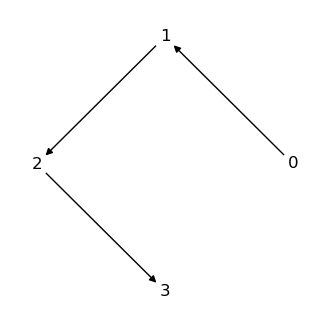

In [5]:
graph = SyntheticDAG(num_latent, DAG_type)
# graph.DAG.remove_arc(4,0)
# graph.DAG.add_arc(3,4)
graph.draw_graph()

In [6]:
# SSM_SER = []

# for i  in range(10):
#     graph = SyntheticDAG(num_latent, DAG_type)
#     G = sample_full_rank_matrix(num_latent, lower_G, upper_G)+torch.eye(num_latent)
#     U_tr,X_tr,noises_tr = graph.sample_scaled(G, 53000)
#     indices = np.random.choice(52000, 3000, replace=False)
#     U = U_tr[indices]
#     X = X_tr[indices]
#     noises = noises_tr[indices]
#     J_X_true = H_X(graph, U, G).detach().numpy()
#     J_X_est = ssm_hess(X, X_tr).detach().numpy()
#     SSM_SER.append(SER(J_X_true, J_X_est))

In [6]:
def noise_estimation(id_layers, layers):
    noise_estimates = np.zeros_like(id_layers)
    noise_estimates[:,0] = id_layers[:,0]
    upstream=[0]
    for layer in layers[1:]:
        for i in layer:
            degree = 2  # Degree of the polynomial features
            poly_features = PolynomialFeatures(degree=degree)
            X_poly = poly_features.fit_transform(id_layers[:,upstream])
            model = LinearRegression()
            model.fit(X_poly, id_layers[:,i])
            noise_estimates[:,i] = id_layers[:,i] - model.predict(X_poly)
        upstream+=layer
    return noise_estimates


In [7]:
U,X,noises = graph.sample_scaled(G, 2000)

In [8]:
id_layers = identify(graph, U, X, G, 95)

-----------------------------------------------------------
Removing Layer 1.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-04-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-04-12


TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

In [9]:
layers = [[0],[1],[2],[3]]
noise_estimates = noise_estimation(id_layers, layers)

NameError: name 'id_layers' is not defined

In [ ]:
noise_estimates.shape

(2998, 4)

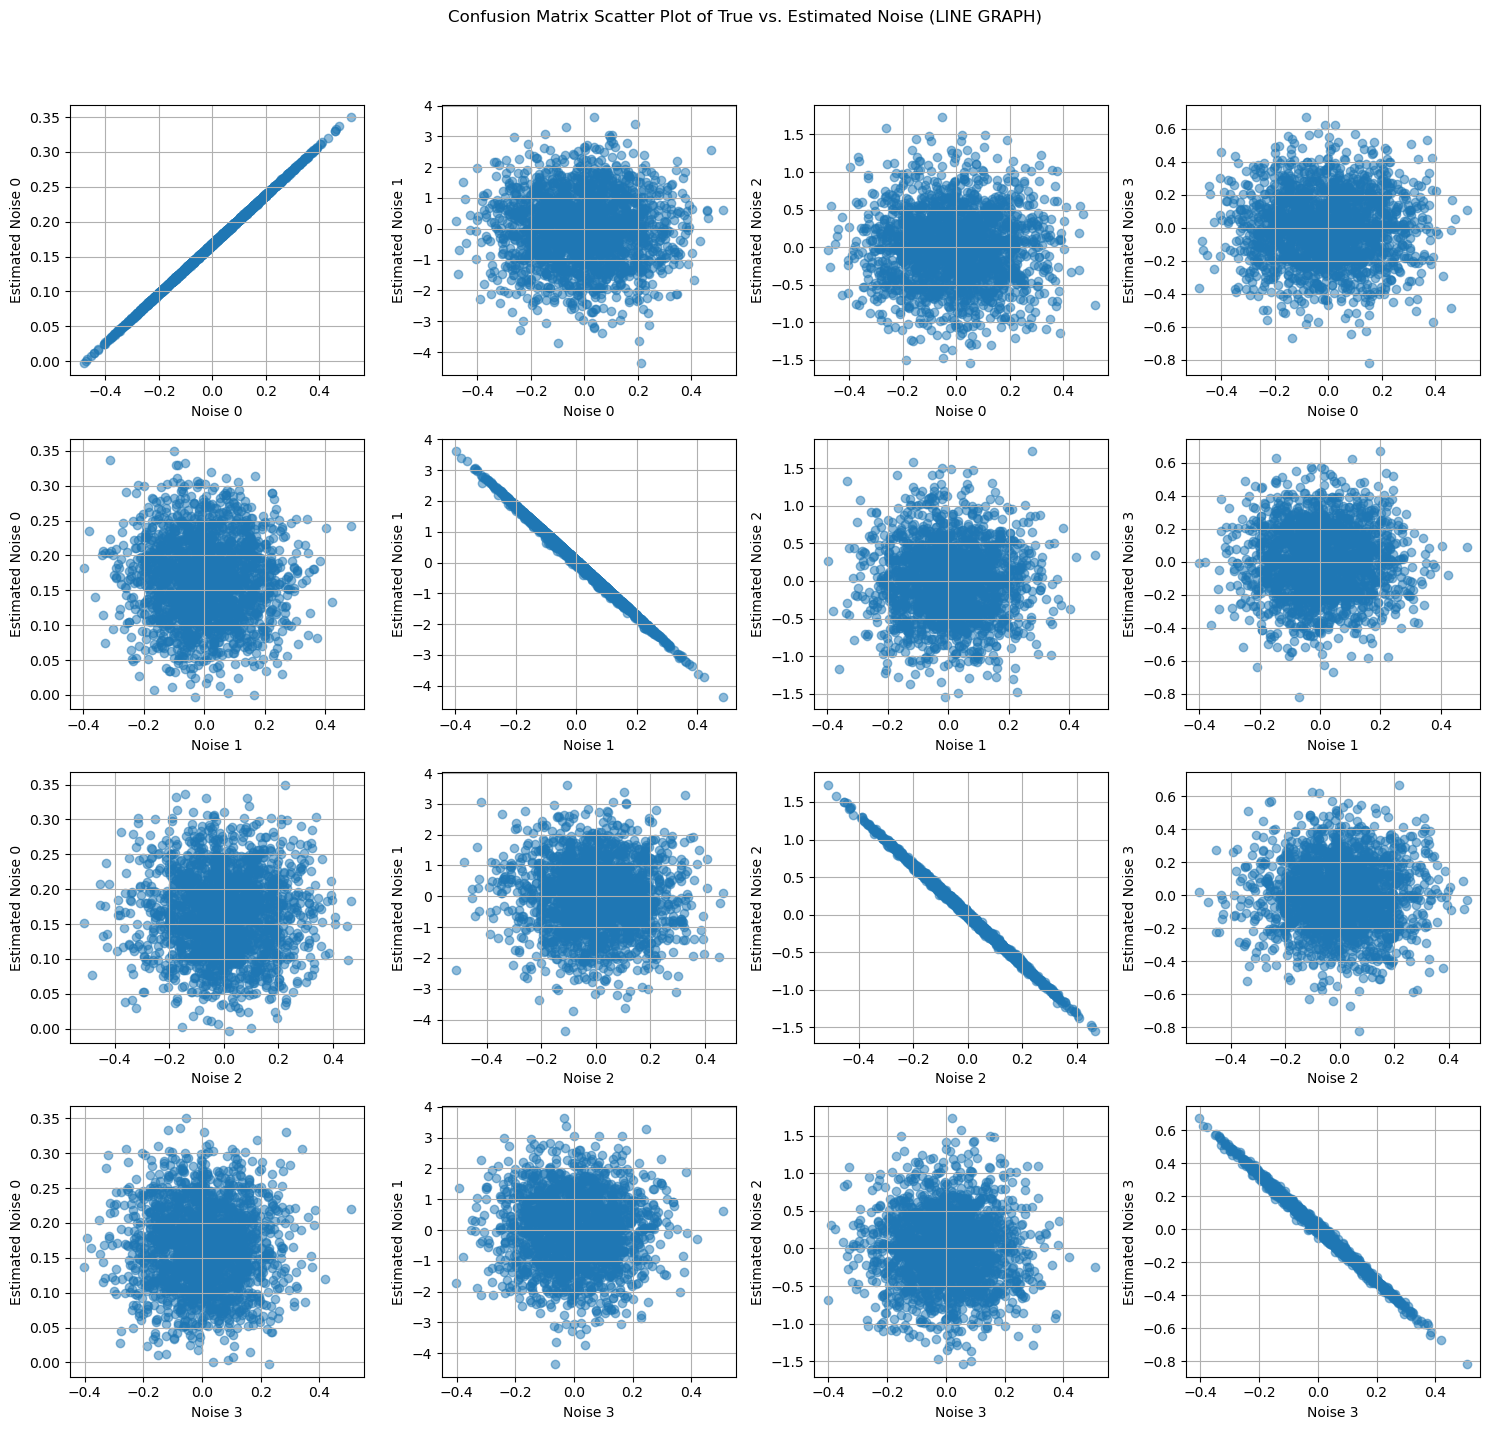

In [13]:
fig, axes = plt.subplots(nrows=num_latent, ncols=num_latent, figsize=(15, 15))
# Set a title for the figure
fig.suptitle('Confusion Matrix Scatter Plot of True vs. Estimated Noise (LINE GRAPH)')

# Iterate over each combination of columns in A and B
for i in range(num_latent):
    for j in range(num_latent):
        ax = axes[i, j]
        ax.scatter(noises[:, i], noise_estimates[:, j], alpha=0.5)  # Plotting the scatter plot
        ax.set_xlabel(f'Noise {i}')  # Set x-axis label
        ax.set_ylabel(f'Estimated Noise {j}')  # Set y-axis label
        ax.grid(True)  # Optional: Adds grid to the plots for better visibility

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()

In [19]:
#Pearson Correlation
#Mutual Information
#RMSE

results = []

for i in range(num_latent):
    for j in range(num_latent):
        # Calculate metrics
        pearson_corr = np.corrcoef(noises[:, i], noise_estimates[:, j])[0, 1]
        mutual_info = mutual_info_regression(noises[:, i].reshape(-1, 1), id_layers[:, j])[0]
        rmse = np.sqrt(mean_squared_error(noises[:, i], id_layers[:, j]))

        # Append the results as a dictionary to the results list
        results.append({
            'Est. Noise': i,
            'True Noise': j,
            'Pearson Correlation': pearson_corr,
            'Mutual Information': mutual_info,
            'RMSE': rmse
        })

# Convert the results list to a DataFrame
df_results = pd.DataFrame(results)

# # Print the DataFrame using tabulate for a nicer format
# print(tabulate(df_results, headers='keys', tablefmt='pipe', showindex=False))

pivot_df = df_results.pivot(index='Est. Noise', columns='True Noise', values='Pearson Correlation')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


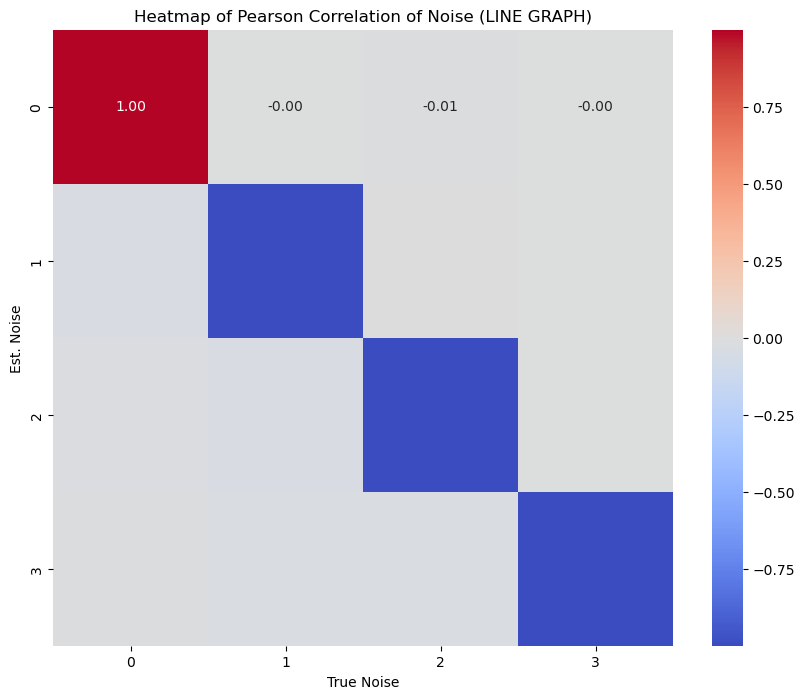

In [20]:
# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Pearson Correlation of Noise (LINE GRAPH)')
plt.show()

In [124]:
J_X = H_X(graph, U, G).detach().numpy()
J_X_bar = np.mean(J_X, axis=0)
J_X_diff = J_X - J_X_bar
J_X_diff_sym = symmetrize(J_X_diff)

In [125]:
m = gp.Model("qcqp")
epsilon = 1e-3
# m.setParam('FeasibilityTol', 1e-3)

x = m.addMVar(shape=J_X_diff_sym.shape[1], lb=-GRB.INFINITY, name="x")

m.setObjective(0, GRB.MINIMIZE)

for i in range(J_X_diff_sym.shape[0]):
    m.addConstr(x @ J_X_diff_sym[i] @ x <= epsilon, name=f"qc{i}_upper")
    m.addConstr(x @ J_X_diff_sym[i] @ x >= -epsilon, name=f"qc{i}_lower")
    
# m.addConstr(x @ x <= 1.1, name="norm_upper")
# m.addConstr(x @ x >= 0.9, name="norm_lower")
m.addConstr(x @ x == 1, name="norm_constr")

m.update()
m.Params.NonConvex = 2
m.setParam('OutputFlag', 0)
m.optimize()

# Results
if m.status == GRB.OPTIMAL:
    print("Optimal solution found.")
    print(f"x: {x.X}")
    # print(f"s: {s.X}")
else:
    print("Optimal solution not found.")

Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found.
x: [ 0.3462246   0.21223213 -0.24840159  0.8794218 ]


In [126]:
v = x.X
max_diff(v, J_X_diff_sym)

1.988796270874227e-05

In [127]:
J = perturb(J_X, 90)
J_bar = np.mean(J, axis=0)
J_diff = J - J_bar
J_diff_sym = symmetrize(J_diff)

In [128]:
np.mean([np.abs(v.T@J_diff_sym[i]@v) for i in range(J_diff_sym.shape[0])])

0.0004526837762266951

(array([ 2.,  0.,  1.,  1.,  0.,  1.,  1.,  5.,  3.,  2.,  2.,  2.,  3.,
         4.,  2.,  4.,  6.,  2., 12., 10., 11., 13.,  9., 21., 24., 16.,
        17., 19., 20., 21., 31., 29., 25., 19., 39., 33., 35., 33., 38.,
        37., 38., 34., 29., 43., 42., 43., 57., 33., 35., 52., 47., 45.,
        36., 40., 54., 47., 35., 34., 44., 44., 40., 36., 42., 37., 27.,
        33., 29., 30., 30., 36., 35., 15., 22., 20., 18., 15.,  9., 22.,
        18.,  8., 11., 10.,  9.,  8.,  8.,  6.,  6.,  5.,  6.,  7.,  2.,
         0.,  6.,  1.,  0.,  3.,  0.,  0.,  1.,  2.]),
 array([-1.65235104e-03, -1.61986551e-03, -1.58737998e-03, -1.55489445e-03,
        -1.52240891e-03, -1.48992338e-03, -1.45743785e-03, -1.42495232e-03,
        -1.39246678e-03, -1.35998125e-03, -1.32749572e-03, -1.29501019e-03,
        -1.26252466e-03, -1.23003912e-03, -1.19755359e-03, -1.16506806e-03,
        -1.13258253e-03, -1.10009699e-03, -1.06761146e-03, -1.03512593e-03,
        -1.00264040e-03, -9.70154863e-04, -9.37669330e

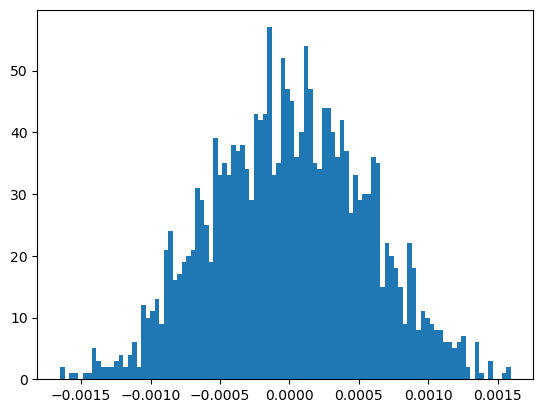

In [129]:
plt.hist([v.T@J_diff_sym[i]@v for i in range(J_diff_sym.shape[0])], bins = 100)
# plt.hist([np.linalg.norm(J_diff_sym[i], 'fro') for i in range(J_diff_sym.shape[0])], bins = 100)

In [35]:
# frobenius_norms = np.linalg.norm(J_diff_sym, ord='fro', axis=(1, 2))
# threshold = np.percentile(frobenius_norms, 75)
# print(threshold)
# filtered_indices = frobenius_norms <= threshold
# J_diff_sym = J_diff_sym[filtered_indices]

In [130]:
m = gp.Model('qcqp')
m.setParam('FeasibilityTol', 1e-6)
m.setParam('OptimalityTol', 1e-6)
m.setParam('Threads', 8) 

# Define dimensions based on J_diff_sym
num_variables = J_diff_sym.shape[0]

# Add variables
x = m.addMVar(shape=J_diff_sym.shape[1], lb=-GRB.INFINITY, name="x")
s = m.addMVar(shape=num_variables, lb=0, name="s")
# y = m.addMVar(shape=num_variables, lb=0, ub=1, name="y_relaxed")

m.setObjective(gp.quicksum(s[i]**2 for i in range(num_variables)), GRB.MINIMIZE)

for i in range(num_variables):
    m.addConstr(x @ J_diff_sym[i] @ x <= s[i])
    m.addConstr(x @ J_diff_sym[i] @ x >= -s[i])

m.addConstr(x @ x == 1, name="norm_constr")

# m.addConstr(gp.quicksum(y) >= num_variables*0.75)

m.update()
m.Params.NonConvex = 2
m.setParam('OutputFlag', 0)  # Enable solver output
m.feasibility()

# Optimize the model
m.optimize()

# Results
solutions = np.empty((J_diff_sym.shape[1],0))
if m.status == GRB.OPTIMAL:
    print("Optimal solution found.")
    sol = x.X
    print(f"x: {sol}")
    print()
    # print(f"s: {s.X}")
    solutions = np.hstack((solutions, sol.reshape(-1, 1)))
else:
    print("Optimal solution not found.")

    #USE GPUS

Set parameter Threads to value 8


INFO:gurobipy:Set parameter Threads to value 8


Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found.
x: [-0.34137542 -0.21095771  0.25176992 -0.88066537]



In [132]:
print(x.X)
print(v)

[-0.34137542 -0.21095771  0.25176992 -0.88066537]
[ 0.3462246   0.21223213 -0.24840159  0.8794218 ]


(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0., 1002.,  996.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.]),
 array([-100.,  -98.,  -96.,  -94.,  -92.,  -90.,  -88.,  -86.,  -84.,
         -82.,  -80.,  -78.,  -76.,  -74.,  -72.,  -70.,  -68.,  -66.,
         -64.,  -62.,  -60.,  -58.,  -56.,  -54.,  -52.,  -5

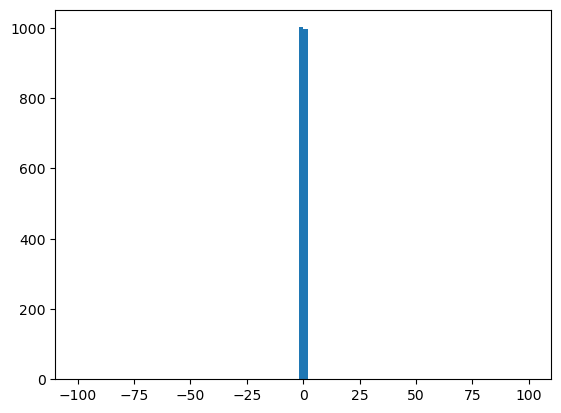

In [133]:
# plt.hist([x.X.T@J_diff_sym[i]@x.X for i in range(J_diff_sym.shape[0])], bins = 100, range=(-100, 100))
plt.hist([v.T@J_diff_sym[i]@v for i in range(J_diff_sym.shape[0])], bins = 100, range=(-100, 100))

In [134]:
# print(np.mean([np.abs(x.X.T@J_diff_sym[i]@x.X) for i in range(J_diff_sym.shape[0])]))
print(np.mean([np.abs(v.T@J_diff_sym[i]@v) for i in range(J_diff_sym.shape[0])]))

0.0004526837762266951


In [135]:
max_diff(x.X, J_X_diff_sym)

0.00021898931335595506

In [144]:
solutions = np.empty((J_X_diff_sym.shape[1],0))
solutions = np.hstack((solutions, x.X.reshape(-1, 1)))
num_leafs, G_hat = fill_full_rank_matrix(solutions)
beta_inv = np.linalg.inv(G_hat)@(G.detach().numpy())
print(beta_inv)

[[-2.99024616e+00  7.65223560e-01  6.62549670e-01 -1.56993843e+00]
 [-4.11026543e+00  3.38383589e+00 -9.03460826e-01 -9.16096915e-03]
 [ 1.27226520e+00 -2.01335019e+00  3.05325371e+00  1.05676996e-04]
 [ 2.17012802e+00  5.92220962e-01 -2.61680921e-01  1.17000870e-02]]


In [52]:
J = Stein_hess_mat(X, eta_G=0.01, eta_H=0.01).detach().numpy()
J_bar = np.mean(J, axis=0)
J_diff = J - J_bar
J_diff_sym = symmetrize(J_diff)

In [53]:
J_diff_sym

array([[[-489.2141   ,  108.77168  ,  292.8006   ,  -80.54075  ],
        [ 108.77168  ,  117.02138  ,  -16.168386 ,   26.72249  ],
        [ 292.8006   ,  -16.168386 , -415.59955  ,  264.32947  ],
        [ -80.54075  ,   26.72249  ,  264.32947  , -264.7501   ]],

       [[-397.39816  ,  348.3584   ,  494.9281   , -335.25266  ],
        [ 348.3584   ,  -73.57822  , -257.7177   ,    6.3289967],
        [ 494.9281   , -257.7177   , -526.85284  ,  242.68132  ],
        [-335.25266  ,    6.3289967,  242.68132  ,   33.14617  ]],

       [[ -41.9546   ,   47.4376   ,   36.952587 ,  -66.58531  ],
        [  47.4376   , -350.77835  , -314.4366   ,  474.7655   ],
        [  36.952587 , -314.4366   , -282.11108  ,  434.45218  ],
        [ -66.58531  ,  474.7655   ,  434.45218  , -640.6508   ]],

       ...,

       [[ 265.38025  ,  -98.98823  , -236.44366  ,  112.1064   ],
        [ -98.98823  ,  259.4787   ,   79.06194  , -117.89468  ],
        [-236.44366  ,   79.06194  ,  135.29466  ,   29.3

In [54]:
J_X_diff_sym

array([[[ 3.3015900e+00,  2.1145687e+01,  2.9892770e+02,  1.3945421e+01],
        [ 2.1145687e+01, -2.7615051e+01,  3.1597964e+02,  2.0951279e+01],
        [ 2.9892770e+02,  3.1597964e+02,  2.8873179e+03,  2.0229672e+02],
        [ 1.3945421e+01,  2.0951279e+01,  2.0229672e+02,  1.8370518e+01]],

       [[-4.9452057e+00, -4.0289787e+01, -2.7761133e+02, -1.5652565e+01],
        [-4.0289787e+01, -4.0568298e+01, -3.4436755e+02, -2.2970646e+01],
        [-2.7761133e+02, -3.4436755e+02, -3.1402031e+03, -1.9704556e+02],
        [-1.5652565e+01, -2.2970646e+01, -1.9704556e+02, -1.1517975e+01]],

       [[ 1.6809540e+00,  2.6428642e+00,  1.0611917e+02,  3.3866692e+00],
        [ 2.6428642e+00, -2.6917053e+01,  9.9821716e+01,  5.1264839e+00],
        [ 1.0611917e+02,  9.9821716e+01,  1.0291260e+03,  8.2103302e+01],
        [ 3.3866692e+00,  5.1264839e+00,  8.2103302e+01,  9.9648285e+00]],

       ...,

       [[-9.1134644e-01,  2.5530281e+00, -6.2929688e+00,  1.3129196e+00],
        [ 2.5530281

In [58]:
df = pd.read_csv('tests/SER_test.csv')
SER = df.iloc[:, 0]
MAC_measurements = df.iloc[:, 1:] 

MAC_mean = MAC_measurements.mean(axis=1)
MAC_std = MAC_measurements.std(axis=1)
MAC_se = MAC_std / np.sqrt(MAC_measurements.shape[1])

# Number of points in the moving average window
window_size = 4

# Compute the moving averages
smoothed_MAC_mean = MAC_mean.rolling(window=window_size, center=True).mean()
smoothed_upper = (MAC_mean + MAC_se).rolling(window=window_size, center=True).mean()
smoothed_lower = (MAC_mean - MAC_se).rolling(window=window_size, center=True).mean()

# Handling NaN values that may appear at the start/end due to the rolling mean
smoothed_MAC_mean = smoothed_MAC_mean.fillna(method='bfill').fillna(method='ffill')
smoothed_upper = smoothed_upper.fillna(method='bfill').fillna(method='ffill')
smoothed_lower = smoothed_lower.fillna(method='bfill').fillna(method='ffill')

# Plotting
plt.figure(figsize=(15, 10))
plt.plot(SER, smoothed_MAC_mean, label='Smoothed MAC', cmap='PuBu')
plt.fill_between(SER, smoothed_lower, smoothed_upper, color='blue', alpha=0.3, label='Confidence Interval')

y_lower, y_upper = plt.ylim()
ssm_location = 5.6768695599372725  # the x-coordinate where the line should be drawn
plt.axvline(x=ssm_location, color='red', linestyle=':', linewidth=2)
y_mid_h = y_lower + 0.75 * (y_upper - y_lower)
plt.text(ssm_location, y_mid_h, '  SSM', color='red', verticalalignment='center', horizontalalignment='left', fontsize=25)

stein_location = 2.0122194828233173
plt.axvline(x=stein_location, color='black', linestyle=':', linewidth=2)
y_mid_l = y_lower + 0.25 * (y_upper - y_lower)
plt.text(stein_location, y_mid_l, '  STEIN', color='black', verticalalignment='center', horizontalalignment='left', fontsize=25)

# plt.title('Smoothed MAC vs SER')
plt.xlabel('SER (dB)')
plt.ylabel('MAC')
plt.grid(False)
# plt.legend()
plt.show()

In [59]:
MAC_mean = MAC_measurements.mean(axis=1)
MAC_std = MAC_measurements.std(axis=1)
MAC_se = MAC_std / np.sqrt(MAC_measurements.shape[1])

In [70]:
# Number of points in the moving average window
window_size = 4

# Compute the moving averages
smoothed_MAC_mean = MAC_mean.rolling(window=window_size, center=True).mean()
smoothed_upper = (MAC_mean + MAC_se).rolling(window=window_size, center=True).mean()
smoothed_lower = (MAC_mean - MAC_se).rolling(window=window_size, center=True).mean()

# Handling NaN values that may appear at the start/end due to the rolling mean
smoothed_MAC_mean = smoothed_MAC_mean.fillna(method='bfill').fillna(method='ffill')
smoothed_upper = smoothed_upper.fillna(method='bfill').fillna(method='ffill')
smoothed_lower = smoothed_lower.fillna(method='bfill').fillna(method='ffill')

# # Define the smoothing factor alpha
# alpha = 0.23  # Alpha can be between 0 and 1

# # Apply exponential smoothing
# smoothed_MAC_mean = MAC_mean.ewm(alpha=alpha, adjust=False).mean()
# smoothed_upper = (MAC_mean + MAC_se).ewm(alpha=alpha, adjust=False).mean()
# smoothed_lower = (MAC_mean - MAC_se).ewm(alpha=alpha, adjust=False).mean()

# # Optionally, fill NaN values if there are any at the start
# smoothed_MAC_mean = smoothed_MAC_mean.fillna(method='bfill')
# smoothed_upper = smoothed_upper.fillna(method='bfill')
# smoothed_lower = smoothed_lower.fillna(method='bfill')

# SER = df.iloc[:, 0]
# MAC_mean = df.iloc[:, 1:].mean(axis=1)
# MAC_std = df.iloc[:, 1:].std(axis=1)
# MAC_se = MAC_std / np.sqrt(df.iloc[:, 1:].shape[1])

# model = ExponentialSmoothing(MAC_mean, trend='add', seasonal=None, damped_trend=False)
# fitted_model = model.fit(smoothing_level=0.2, smoothing_slope=0.4, optimized=True)

# # Obtain the smoothed series
# smoothed_MAC_mean = fitted_model.fittedvalues

# # Calculate smoothed upper and lower confidence intervals
# smoothed_upper = smoothed_MAC_mean + 1.96 * MAC_se
# smoothed_lower = smoothed_MAC_mean - 1.96 * MAC_se

# # Optionally, fill NaN values if there are any at the start
# smoothed_MAC_mean = smoothed_MAC_mean.fillna(method='bfill')
# smoothed_upper = smoothed_upper.fillna(method='bfill')
# smoothed_lower = smoothed_lower.fillna(method='bfill')

/var/folders/4w/ydwt6t6121q_3f2yzbm6znww0000gn/T/ipykernel_34897/3421282365.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smoothed_MAC_mean = smoothed_MAC_mean.fillna(method='bfill').fillna(method='ffill')
/var/folders/4w/ydwt6t6121q_3f2yzbm6znww0000gn/T/ipykernel_34897/3421282365.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smoothed_upper = smoothed_upper.fillna(method='bfill').fillna(method='ffill')
/var/folders/4w/ydwt6t6121q_3f2yzbm6znww0000gn/T/ipykernel_34897/3421282365.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smoothed_lower = smoothed_lower.fillna(method='bfill').fillna(method='ffill')


In [76]:
plt.rcParams.update({'font.size': 22})

AttributeError: Line2D.set() got an unexpected keyword argument 'cmap'

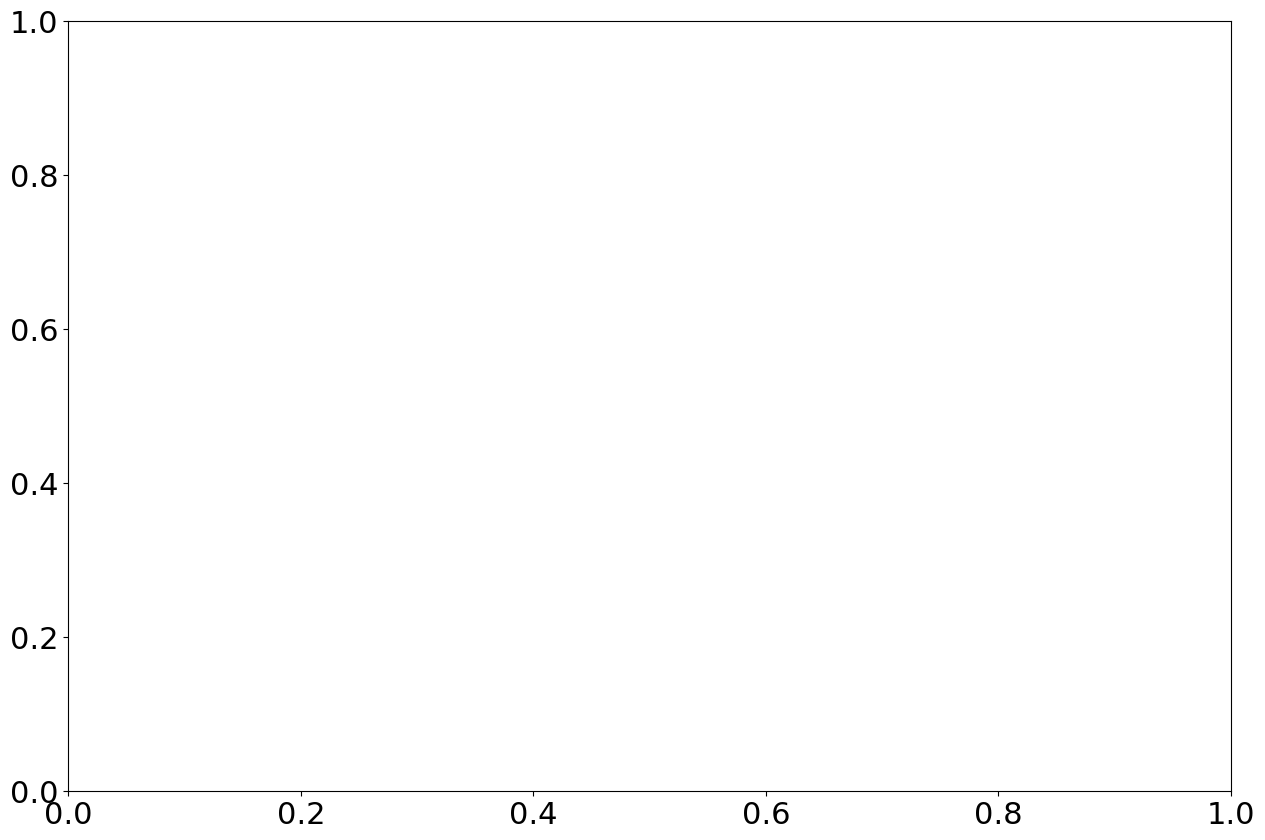

In [84]:
# Plotting
plt.figure(figsize=(15, 10))
plt.plot(SER, smoothed_MAC_mean, label='Smoothed MAC', cmap='PuBu')
plt.fill_between(SER, smoothed_lower, smoothed_upper, color='blue', alpha=0.3, label='Confidence Interval')

y_lower, y_upper = plt.ylim()
ssm_location = 5.6768695599372725  # the x-coordinate where the line should be drawn
plt.axvline(x=ssm_location, color='red', linestyle=':', linewidth=2)
y_mid_h = y_lower + 0.75 * (y_upper - y_lower)
plt.text(ssm_location, y_mid_h, '  SSM', color='red', verticalalignment='center', horizontalalignment='left', fontsize=25)

stein_location = 2.0122194828233173
plt.axvline(x=stein_location, color='black', linestyle=':', linewidth=2)
y_mid_l = y_lower + 0.25 * (y_upper - y_lower)
plt.text(stein_location, y_mid_l, '  STEIN', color='black', verticalalignment='center', horizontalalignment='left', fontsize=25)

# plt.title('Smoothed MAC vs SER')
plt.xlabel('SER (dB)')
plt.ylabel('MAC')
plt.grid(False)
# plt.legend()
plt.show()

In [7]:
def write_to_csv(ser, test_num, value, filename='tests/SER_test.csv'):
    # Read all data from the CSV file
    with open(filename, 'r', newline='') as file:
        reader = list(csv.reader(file))

    # Modify the specific row and column
    reader[ser][test_num+1] = value

    # Write everything back to the CSV
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(reader)

In [8]:
# first_column = np.arange(5, 101, 5)

# # Create a DataFrame with 20 rows and 11 columns of zeros
# df = pd.DataFrame(0, index=np.arange(len(first_column)), columns=np.arange(11))

# # Fill the first column with the sequence
# df.iloc[:, 0] = first_column

# # Save to CSV
# df.to_csv('tests/SER_test.csv', index=False)

# print("CSV file created with specified data.")

In [10]:
layers = [[0], [1], [2], [3]]

def noise_estimation(id_layers, layers):
    noise_estimates = np.zeros_like(id_layers)
    noise_estimates[:,0] = id_layers[:,0]
    upstream=[0]
    for layer in layers[1:]:
        for i in layer:
            degree = 2  # Degree of the polynomial features
            poly_features = PolynomialFeatures(degree=degree)
            X_poly = poly_features.fit_transform(id_layers[:,upstream])
            model = LinearRegression()
            model.fit(X_poly, id_layers[:,i])
            noise_estimates[:,i] = id_layers[:,i] - model.predict(X_poly)
        upstream+=layer
    return noise_estimates


In [11]:
def mac(noises, noises_estimates):
    correlation_coeffs = []
    for col in range(noises.shape[1]):
        correlation_matrix = np.corrcoef(noises[:, col], noises_estimates[:, col])
        # print(correlation_matrix)
        correlation_coeff = correlation_matrix[0, 1]
        correlation_coeffs.append(abs(correlation_coeff))
    return np.mean(correlation_coeffs)


In [12]:
DAG_type = 'line'
num_latent = 4
lower_G = -1 #min possibel value in G or G_hat
upper_G = 1 #max possible value in G or G_hat
num_samples = 3000

In [10]:
i = 6
ser = (i-1)*5
print(ser)

25


In [13]:
i = 6
ser = (i-1)*5
test_num = 9
while test_num < 10:
    print(f"SER DB: {ser}, 'TEST #: {test_num}")
    graph = SyntheticDAG(num_latent, DAG_type)
    G = sample_full_rank_matrix(num_latent, lower_G, upper_G)+torch.eye(num_latent)
    U,X,noises = graph.sample_scaled(G, num_samples)
    try:
        id_layers = identify(graph, U, X, G, ser)
        noise_estimates = noise_estimation(id_layers, layers)
        MAC = mac(noises, noise_estimates)
        write_to_csv(i, test_num, MAC)
        test_num+=1
    except:
        # print('BOTCH')
        continue


SER DB: 25, 'TEST #: 9
-----------------------------------------------------------
Removing Layer 1.
-----------------------------------------------------------
Calculating Jacobian Estimates...
With SER dB: 25.00000000000015
Done.

Finding Optimal G_hat...
Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-04-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-04-12


Set parameter TimeLimit to value 120


INFO:gurobipy:Set parameter TimeLimit to value 120


Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found:
[-0.11797297 -0.26853402  0.81103023  0.50616383]

No feasible solution found.
Done.

U_hat as a linear combination of U:
[[ -2.49126171   7.88594102  -1.07353087   2.49347902]
 [  0.86545096  -2.40721219   2.13601596  -1.82781842]
 [  6.17614944 -18.78258188   2.88660048  -5.32909315]
 [ -5.66085766  16.5190509   -4.74389026   6.16584204]]

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 2.
-----------------------------------------------------------
Calculating Jacobian Estimates...
With SER dB: 24.999999999999737
Done.

Finding Optimal G_hat...
Set parameter TimeLimit to value 120


INFO:gurobipy:Set parameter TimeLimit to value 120


Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found:
[ 0.58750541 -0.75185187 -0.29925936]

No feasible solution found.
Done.

U_hat as a linear combination of U:
[[  0.42091703  -0.79499911   2.68130286]
 [-27.10900713  80.36104545 -19.91700451]
 [ 26.85551823 -79.82281957  19.94175778]]

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 3.
-----------------------------------------------------------
Calculating Jacobian Estimates...
With SER dB: 24.999999999999915
Done.

Finding Optimal G_hat...
Set parameter TimeLimit to value 120


INFO:gurobipy:Set parameter TimeLimit to value 120


Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found:
[ 0.70099666 -0.71316455]

No feasible solution found.
Done.

U_hat as a linear combination of U:
[[-38.19635171 113.36809609]
 [ -0.50917735   1.3594512 ]]

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 4.
-----------------------------------------------------------
Peeled off 1 nodes.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel on

In [17]:
#STEIN

# for i in range(5,0,-1):
#     ser = (i-1)*5
#     test_num = 5
#     while test_num < 10:
#         print(f"SER DB: {ser}, 'TEST #: {test_num}")
#         graph = SyntheticDAG(num_latent, DAG_type)
#         G = sample_full_rank_matrix(num_latent, lower_G, upper_G)+torch.eye(num_latent)
#         U,X,noises = graph.sample_scaled(G, num_samples)
#         try:
#             id_layers = identify(graph, U, X, G, ser)
#             noise_estimates = noise_estimation(id_layers, layers)
#             MAC = mac(noises, noise_estimates)
#             write_to_csv(i, test_num, MAC)
#             test_num+=1
#         except:
#             continue

        # try:
        #     id_layers = identify_e(X, estimator='stein')
        #     noise_estimates = noise_estimation(id_layers, layers)
        #     MAC = mac(noises, noise_estimates)
        #     table[i,j] = MAC
        # except:
        #     continue


MACS = []
num_samples = 1000000
j=0
while j < 5:
    graph = SyntheticDAG(num_latent, DAG_type)
    G = sample_full_rank_matrix(num_latent, lower_G, upper_G)+torch.eye(num_latent)
    # U, X, noises = graph.sample_scaled(G, num_samples)
    U_tr,X_tr,noises_tr = graph.sample_scaled(G, num_samples)
    U = U_tr[:6000]
    X = X_tr[:6000]
    noises = noises_tr[:6000]
    try:
        id_layers = identify_e(X, X_tr, estimator='ssm')
        noise_estimates = noise_estimation(id_layers, layers)
        MACS.append(mac(noises, noise_estimates))
        # table[i,j] = MAC
    except:
        continue
    print(f'{j} done.')
    j+=1

Starting...
-----------------------------------------------------------
Removing Layer 1.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found.
x: [ 0.25472434 -0.82033202  0.30311928 -0.41266158]

Done.

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 2.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found.
x: [-0.79345325  0.53738345  0.28574633]

Done.

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 3.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found.
x: [ 0.69211509 -0.72178716]

Done.

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 4.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Peeled off 1 nodes.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel

INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found.
x: [ 0.19800813 -0.10948884  0.46198587 -0.85753952]

Done.

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 2.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found.
x: [ 0.68058761 -0.69001734 -0.24632616]

Done.

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 3.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found.
x: [ 0.61823399 -0.78599411]

Done.

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 4.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Peeled off 1 nodes.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel

INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found.
x: [ 0.57046606  0.53487844  0.60018385 -0.16808594]

Done.

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 2.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found.
x: [ 0.6410659  -0.60129357 -0.47694922]

Done.

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 3.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found.
x: [-0.04018617  0.99919221]

Done.

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 4.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Peeled off 1 nodes.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel

INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution not found.
Done.

Peeled off 0 nodes.
-----------------------------------------------------------
Removing Layer 2.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Starting...
-----------------------------------------------------------
Removing Layer 1.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found.
x: [ 0.742515    0.62089748 -0.06752486  0.24207063]

Done.

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 2.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found.
x: [ 0.90386654  0.22358557 -0.36473933]

Done.

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 3.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found.
x: [-0.87559444  0.48304698]

Done.

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 4.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Peeled off 1 nodes.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel

INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found.
x: [-0.05542296  0.13085223 -0.93959925  0.31138278]

Done.

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 2.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found.
x: [ 0.5052206   0.02219492 -0.86270478]

Done.

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 3.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found.
x: [ 0.40220152 -0.91555117]

Done.

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 4.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Peeled off 1 nodes.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel

In [18]:
np.savetxt('ssm_1M.csv', np.array(MACS), delimiter=',')

In [14]:
num_samples = 100000

In [15]:
graph = SyntheticDAG(num_latent, DAG_type)

In [16]:
G = sample_full_rank_matrix(num_latent, lower_G, upper_G)+torch.eye(num_latent)

In [17]:
U, X, noises = graph.sample_scaled(G, num_samples)

In [22]:
eta_G=0.10911070444147038
eta_H=0.9033964848783047
from stein import *

In [2]:
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
np.savetxt('test.csv', np.array([1,1,1,1]), delimiter=',')

In [23]:
Stein_hess_mat(X, eta_G=eta_G, eta_H=eta_H)

: 

In [ ]:
# np.savetxt("tests/stein_t3_p2.csv.", table, delimiter=',')

In [69]:
# np.mean(table, axis=1)

In [31]:
ssm_data = np.genfromtxt('tests/ssm_t2.csv', delimiter=',')
stein_data = np.genfromtxt('tests/stein_t1.csv', delimiter=',')

In [34]:
df = pd.read_csv('tests/t1.csv')
df['stein_mean'] = np.mean(stein_data, axis=1)
df['stein_std'] = np.std(stein_data, axis=1)
df['ssm_mean'] = np.mean(ssm_data, axis=1)
df['ssm_std'] = np.std(ssm_data, axis=1)
df

,num_samples,oracle_mean,oracle_std,stein_mean,stein_std,ssm_mean,ssm_std
0,2000,0.999004,0.000571,0.409714,0.148725,0.358009,0.152960
1,4000,0.999480,0.000160,0.409813,0.097900,0.477190,0.156209
2,6000,0.999524,0.000087,0.471424,0.177639,0.450370,0.142546
3,8000,0.999718,0.000059,0.441767,0.149957,0.500893,0.185681
4,10000,0.999827,0.000054,0.485958,0.235287,0.440397,0.222497


In [79]:
df.loc[len(df)] = [int(1000000)] + [None] * (len(df.columns)-1)
# 

In [84]:
MACS

[0.21501857915417885,
 0.45836793881062476,
 0.6183813240251544,
 0.5965478418276909,
 0.25111671279197884]

In [92]:
MACS = np.genfromtxt('ssm_100K.csv')

In [93]:
MACS

array([0.54453941, 0.5186175 , 0.41331579, 0.21902716, 0.45318999])

In [94]:
df.at[5, 'ssm_mean'] = np.mean(MACS)
df.at[5, 'ssm_std'] = np.std(MACS)

In [97]:
# df = df.iloc[:-1]
df.to_csv('estimator_test_results.csv', index=False)

In [46]:
# result = pd.DataFrame({
#     'Samples': list(df['num_samples']),
#     'Oracle': [f"{round(mean,3)} ± {round(std,3)}" for mean, std in zip(df['oracle_mean'], df['oracle_std'])],
#     'Stein': [f"{round(mean,3)} ± {round(std,3)}" for mean, std in zip(df['stein_mean'], df['stein_std'])],
#     'SSM': [f"{round(mean,3)} ± {round(std,3)}" for mean, std in zip(df['ssm_mean'], df['ssm_std'])]
# })

# print(result.to_latex(index=False))